In [14]:
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    Motifs = list(set(list(R.loc[R['E.tissues']>=1]['motif'])))
    for tis in TISSUES:
        #Review motif policies here
        field= 'eSTR.'+SHORTEN[tis]
        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #motifs frequency among estrs
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
            #
        Mapdata[tis]=All
    #Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    ODD = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[2] for s in  Mapdata[T] if s[0]==m ]
            odd = [s[3] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
            if odd==[]:
                ODD[i][j] =0
            else:
                ODD[i][j] =odd[0]                
    return Mset,ODD,Mapdata, pdata


SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}

TISSUES = [item for item in list(SHORTEN.keys())]
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
#feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'
annotation='/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv'


In [15]:
"""Here we look at STR that fall within genes boundaries"""

#Anotation gene
ANOT = pd.read_csv(annotation, sep=',')
Genes = ANOT[['gene.chr','gene.start','gene.stop']].copy()
Genes.to_csv('genes.bed', sep='\t',index=None, header=None)

#Only work with STR in gene boundary
regression = pd.read_csv(regr, sep='\t')   
regr_subset = regression[["chrom","str.start",'str.end','str.id',"gene","E.tissues", "motif" ]]
regr_subset.to_csv('reg.bed', sep='\t',index=None, header=None)

#Intersect regression and features [within gene boundaries]
command = "bedtools intersect -a reg.bed -b genes.bed -wb -names Gene >Intersect.bed"
returned_value = os.system(command)
#OUT
inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
inner.columns=["chrom","str.start",'str.end','str.id',"gene","E.tissues","motif",'chrom_x','gene.start','gene.end']    

#Subselect motifs and position 
data = inner[['chrom','str.start','str.end','gene','str.id',"E.tissues","motif"]].copy()
data1 = pd.merge(data, regression, on=list(data.columns), how='inner')
print(data.shape, data1.shape)

(59980, 7) (59891, 94)


In [21]:
#Non strand annotated
Mset,ODD,Mapdata,pdata = getfisher(data1,TISSUES)
#clustered heatmap by correlation
df1 = pd.DataFrame(ODD)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset; print(df1.shape)
'''
metric="correlation"
Motifs present in heatmap are those observed across tissues  VV
'''
motifs = sorted([x for x in df1.columns if x  in Mset]) ; len(motifs)

108
(17, 108)


0

In [ ]:
"""Order it?"""
df = df1[motifs].copy()
df.loc['Total']= df.sum()
df = df.sort_values(by='Total', axis=1)
df = df.drop(['Total'])
#plot Enrichrment of motifs at eSTRs..

108


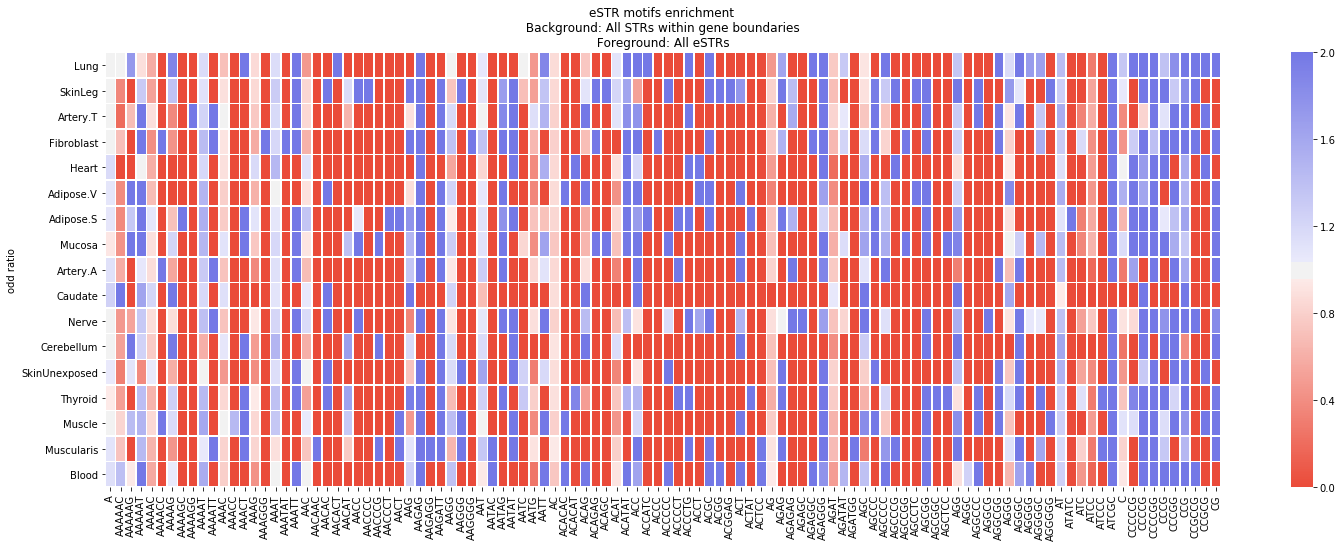

In [23]:
#plot Motifs Enrichrment 
df1 = df1[motifs]
fig, ax = plt.subplots(figsize=(25, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df1, cmap=cmap, annot_kws={"size": 8},
            vmin=0, vmax=2, linewidths=0.5   );
plt.ylabel("odd ratios")
plt.title('eSTR motifs enrichment \n Background: All STRs within gene boundaries \n Foreground: All eSTRs ')
plt.show()

(17, 108)


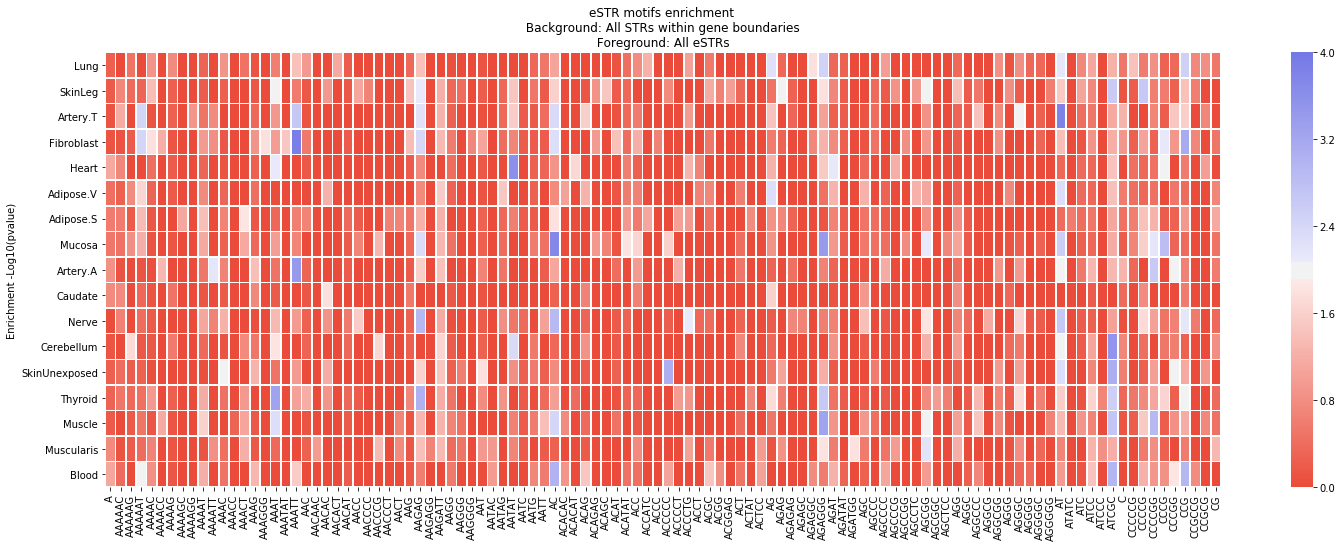

In [29]:
df2 = pd.DataFrame(pdata)
df2.index = [SHORTEN[t] for t in TISSUES]
df2.columns = Mset; print(df2.shape)


df2 = df2[motifs]
fig, ax = plt.subplots(figsize=(25, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df2, cmap=cmap, annot_kws={"size": 8},
            vmin=0, vmax=4, linewidths=0.5   );
plt.ylabel("Enrichment -Log10(pvalue)")
plt.title('eSTR motifs enrichment \n Background: All STRs within gene boundaries \n Foreground: All eSTRs ')
plt.show()

In [ ]:
"""
#Subselect motifs and position 

#Strand maybe?
strands = pd.read_csv(strand, sep='\t', header=None)
strands.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
st_data = pd.merge(data1, strands[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
#annotation
annot = pd.read_csv(annotation, sep=',')
annot['gene']=annot['gene.id']               
annot['chrom'] = annot['gene.chr']
st_data = pd.merge(st_data, annot[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
st_data['Motif']=st_data['For_motif'].where(st_data['gene.strand'] == '+', st_data['Rev_motif']) #Strand annotation

"""